# Energy Production Forecast for Portugal: A Hybrid Modeling Approach

This notebook presents a comprehensive analysis and forecasting of Portugal's renewable and non-renewable energy production. A hybrid forecasting model that combines time series decomposition with specialized algorithms for each component:

1. **Time Series Decomposition**: Breaking down energy production data into trend, seasonal, and residual components
2. **Component-Specific Modeling**:
    - Trend component: Exponential Smoothing or MLP Regressor (2 different approaches)
    - Seasonal component: Multiplicative seasonality Exponential Smoothing
    - Residual component: Support Vector Regression (SVR) or MLP Neural Network (2 different approaches)

The hybrid approach allows us to capture different patterns at various time scales, resulting in higher accuracy forecasts than traditional single-model approaches.

## Imports

In [1]:
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

import optuna

from typing import Tuple, Union

import warnings
warnings.filterwarnings("ignore")

/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Auxiliary Functions

In [2]:
def create_lagged_features(series, n_lags=5):
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df.dropna(inplace=True)
    return df


## Constants

In [3]:
# File paths
PATH = "../dataset"
DATA_FILENAME = f"{PATH}/data.csv"

SEASONAL_PERIODS = 365

SEED = 42

set2_palette = sns.color_palette("Set2")
palette = [set2_palette[2], set2_palette[1]]
sns.set_palette(palette)

## Data Loading

In [4]:
# Load the dataset from CSV file
df = pd.read_csv(DATA_FILENAME)

# Convert the timestamp column to datetime format and set it as the index
df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])
df = df.set_index('Data e Hora')
df.head()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2011-01-01,107.975628,73.076341,63.952042,2.142578,0.122491,0.0,6.859230,34.484478,4.3443,28.367837,1.772341,0.414810,12.4186,0.0852
2011-01-02,109.657562,71.219553,62.732572,1.469945,0.197608,0.0,6.819428,37.876984,0.7383,35.343969,1.794715,0.561025,20.8615,0.0000
2011-01-03,150.642916,74.660080,63.158904,4.503582,0.166772,0.0,6.830821,74.808327,14.9438,55.179956,4.684572,1.174509,13.4903,1.0916
2011-01-04,159.833303,101.106584,64.904843,28.734425,0.256511,0.0,7.210805,58.567678,4.8496,48.985982,4.732096,0.159041,9.3552,0.7629
2011-01-05,170.854279,133.687873,67.566754,58.869586,0.208719,0.0,7.042814,36.428947,4.6337,27.003927,4.791320,0.737460,6.7881,6.8363


In [5]:
df_renewable = df['producao_renovavel']
df_non_renewable = df['producao_nao_renovavel']

## Train, Validation, and Test split

In [6]:
# First, perform the decomposition for renewable and non-renewable energy
decomposition_renewable = seasonal_decompose(df_renewable, model='multiplicative', period=SEASONAL_PERIODS)
decomposition_non_renewable = seasonal_decompose(df_non_renewable, model='multiplicative', period=SEASONAL_PERIODS)

# Extract the components with consistent naming
# Remove values before the first trend index
renewables_trend_component = decomposition_renewable.trend.dropna().rename("trend")
first_trend_index = renewables_trend_component.index[0]
last_trend_index = renewables_trend_component.index[-1]

non_renewables_trend_component = decomposition_non_renewable.trend.dropna().rename("trend")
first_trend_index = non_renewables_trend_component.index[0]
last_trend_index = non_renewables_trend_component.index[-1]

# Align seasonal and residual components with the trend component
renewables_seasonal_component = decomposition_renewable.seasonal[first_trend_index:last_trend_index].rename("seasonal")
renewables_residual_component = decomposition_renewable.resid[first_trend_index:last_trend_index].rename("residual")

non_renewables_seasonal_component = decomposition_non_renewable.seasonal[first_trend_index:last_trend_index].rename("seasonal")
non_renewables_residual_component = decomposition_non_renewable.resid[first_trend_index:last_trend_index].rename("residual")

# Split each component into training and testing sets
split_ratio = 0.8
split_index = int(len(renewables_trend_component) * split_ratio)

### Renewables

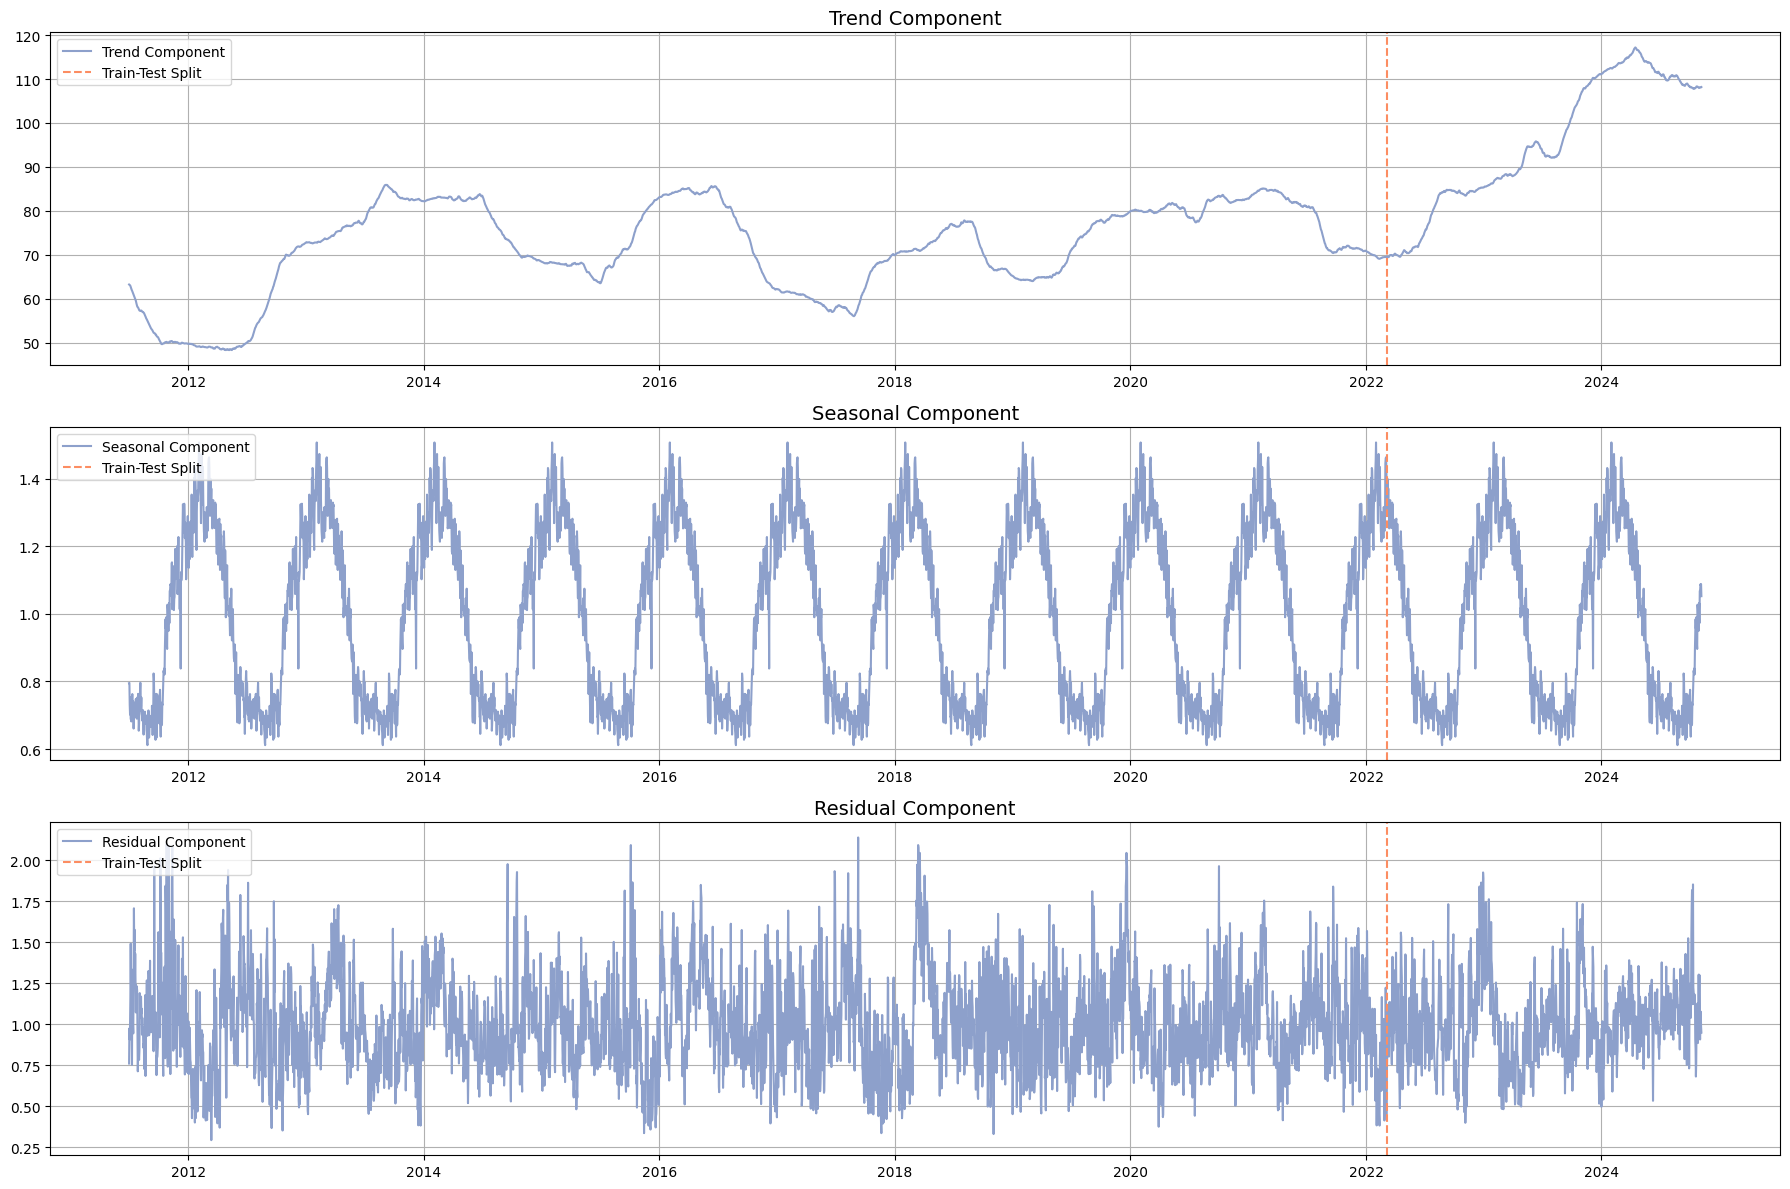

In [7]:
plt.figure(figsize=(18, 12))

# Plot trend
plt.subplot(3, 1, 1)
plt.plot(renewables_trend_component, label='Trend Component')
plt.axvline(x=renewables_trend_component.index[split_index], color=palette[1], linestyle='--', label='Train-Test Split')
plt.title('Trend Component', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Plot seasonality
plt.subplot(3, 1, 2)
plt.plot(renewables_seasonal_component, label='Seasonal Component')
plt.axvline(x=renewables_seasonal_component.index[split_index], color=palette[1], linestyle='--', label='Train-Test Split')
plt.title('Seasonal Component', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Plot residuals
plt.subplot(3, 1, 3)
plt.plot(renewables_residual_component, label='Residual Component')
plt.axvline(x=renewables_residual_component.index[split_index], color=palette[1], linestyle='--', label='Train-Test Split')
plt.title('Residual Component', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Non-renewables

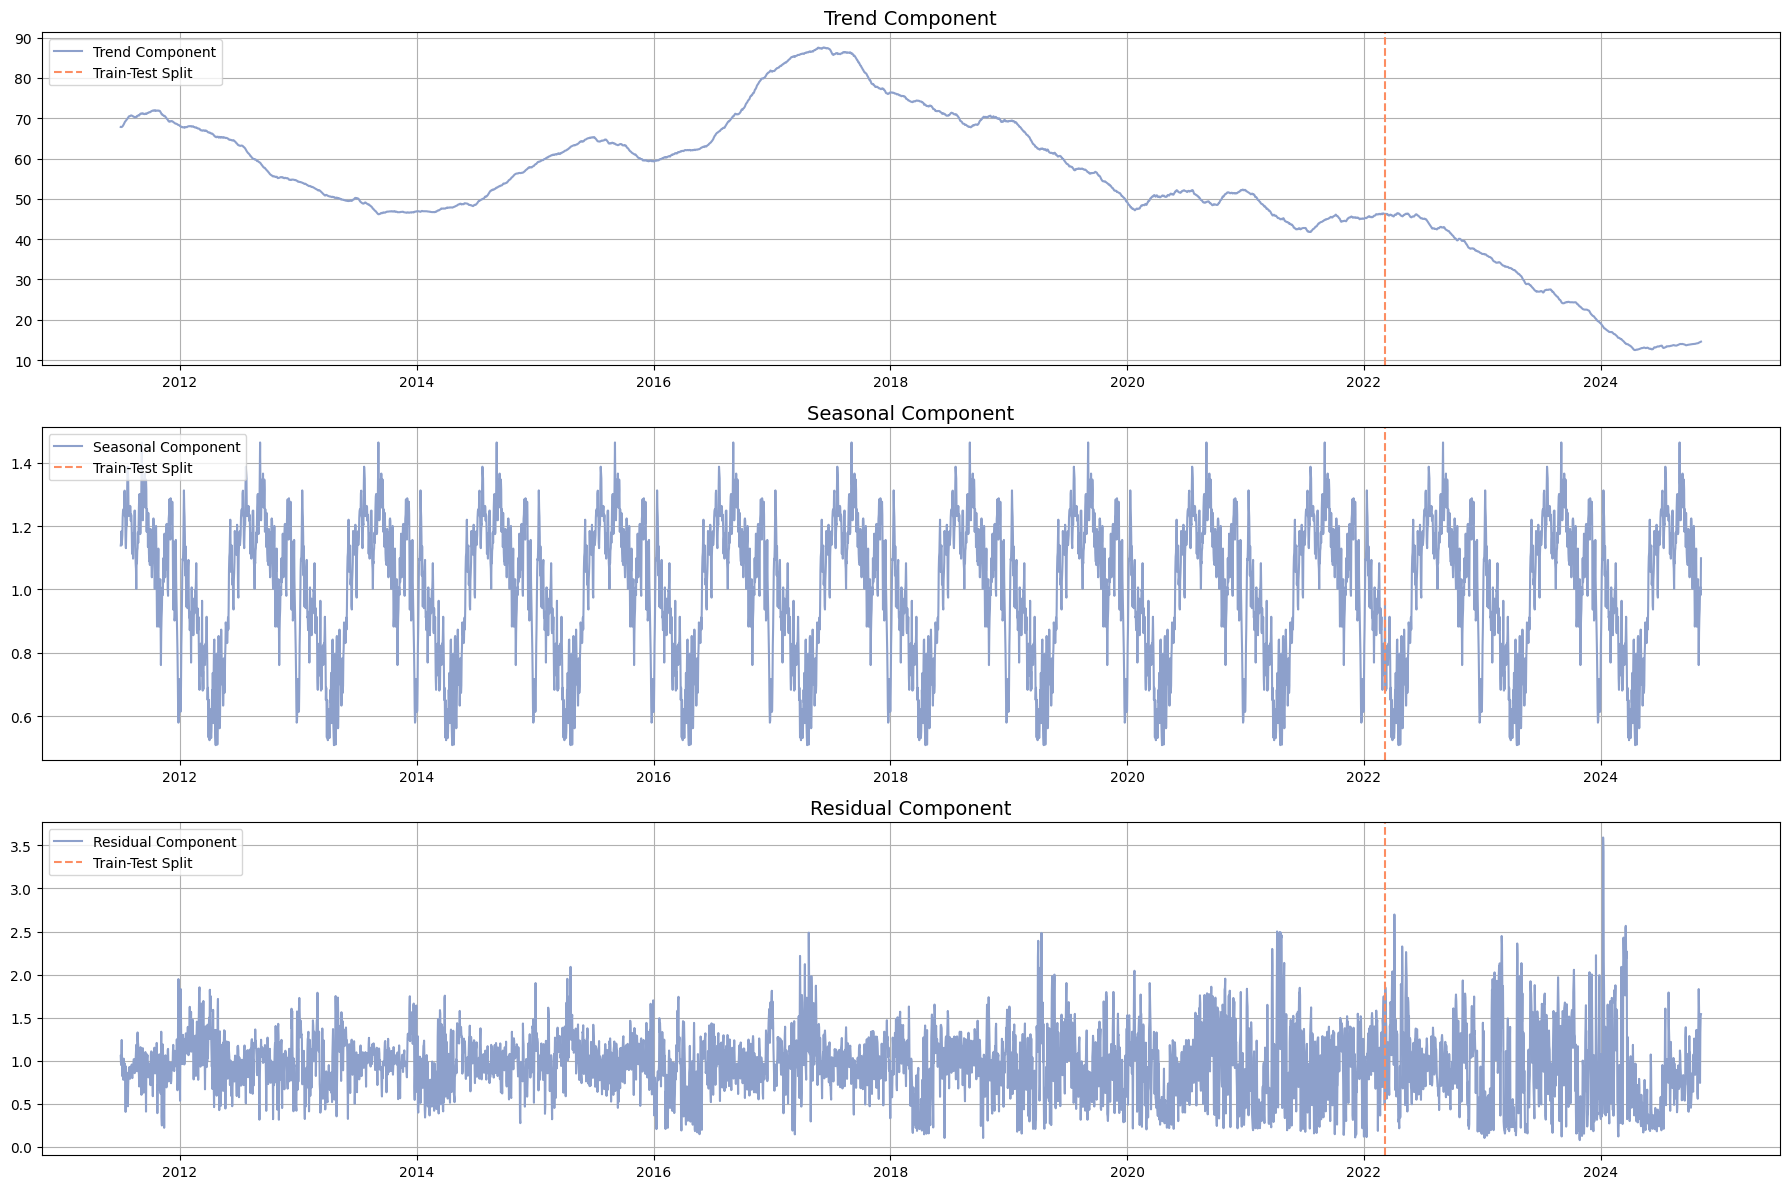

In [8]:
plt.figure(figsize=(18, 12))

# Plot trend
plt.subplot(3, 1, 1)
plt.plot(non_renewables_trend_component, label='Trend Component')
plt.axvline(x=non_renewables_trend_component.index[split_index], color=palette[1], linestyle='--', label='Train-Test Split')
plt.title('Trend Component', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Plot seasonality
plt.subplot(3, 1, 2)
plt.plot(non_renewables_seasonal_component, label='Seasonal Component')
plt.axvline(x=non_renewables_seasonal_component.index[split_index], color=palette[1], linestyle='--', label='Train-Test Split')
plt.title('Seasonal Component', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Plot residuals
plt.subplot(3, 1, 3)
plt.plot(non_renewables_residual_component, label='Residual Component')
plt.axvline(x=non_renewables_residual_component.index[split_index], color=palette[1], linestyle='--', label='Train-Test Split')
plt.title('Residual Component', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

## Trend Analysis

### Multi-Layer Perceptron

In [9]:
def build_mlp_regressor(
    hidden_layers_sizes: Tuple[int, int],
    activation: str = 'relu',
    solver: str = 'adam',
    alpha: float = 0.0001,
    learning_rate: str = 'constant',
    learning_rate_init: float = 0.001,
    max_iter: int = 1000,
    early_stopping: bool = True,
    validation_fraction: float = 0.1,
    n_iter_no_change: int = 10,
    seed: Union[None, int] = None
    ) -> MLPRegressor:
    """
    Build and configure an MLPRegressor model with customizable parameters.
    
    Parameters:
    hidden_layers_sizes: Tuple of integers specifying neurons in each hidden layer
    activation: Activation function ('identity', 'logistic', 'tanh', 'relu')
    solver: Weight optimization solver ('lbfgs', 'sgd', 'adam')
    alpha: L2 regularization term (ridge regression)
    learning_rate: Learning rate schedule ('constant', 'invscaling', 'adaptive')
    learning_rate_init: Initial learning rate
    max_iter: Maximum number of iterations
    early_stopping: Whether to use early stopping
    validation_fraction: Fraction of training data for validation
    n_iter_no_change: Max iterations with no improvement for early stopping
    seed: Random state for reproducibility
    
    Returns:
    Configured MLPRegressor instance
    """
    return MLPRegressor(
    hidden_layer_sizes=hidden_layers_sizes,
    activation=activation,
    solver=solver,
    alpha=alpha,
    learning_rate=learning_rate,
    learning_rate_init=learning_rate_init,
    max_iter=max_iter,
    random_state=seed,
    early_stopping=early_stopping,
    validation_fraction=validation_fraction,
    n_iter_no_change=n_iter_no_change
    )

#### Fine-tuning

In [10]:
def optimize_mlp_for_trend(trend_component, n_trials=200):
    """
    Optimize MLP hyperparameters for trend forecasting using Optuna.
    
    Args:
        trend_train: Full dataset for trend component
        n_trials: Number of optimization trials
        
    Returns:
        dict: Best hyperparameters
    """
    def objective(trial: optuna.trial.Trial):
        # Define hyperparameters to optimize
        hidden_layers = []
        for i in range(2):
            hidden_layers.append(trial.suggest_int(f'n_units_layer_{i}', 10, 50, step=5))
        
        # Create MLP with the suggested hyperparameters
        mlp = build_mlp_regressor(
            hidden_layers_sizes=tuple(hidden_layers),
            seed=SEED
        )
        
        # Create lagged features
        n_lags = trial.suggest_int('n_lags', 1, 5)
        df_lagged = create_lagged_features(trend_component, n_lags=n_lags)
        
        # Train-test split
        test_split_ratio = 0.8
        split = int(len(df_lagged) * test_split_ratio)
        train_df = df_lagged.iloc[:split]
        test_df = df_lagged.iloc[split:]

        X_train = train_df.drop('y', axis=1).values
        y_train = train_df['y'].values
        X_test = test_df.drop('y', axis=1).values
        y_test = test_df['y'].values
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        try:
            mlp.fit(X_train_scaled, y_train)
            y_pred = mlp.predict(X_test_scaled)
            mae = mean_absolute_error(y_test, y_pred)
            return mae
        except Exception as e:
            print(f"Error during training: {e}")
            return float('inf')
    
    # Create study and optimize
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get best hyperparameters
    best_params = study.best_params
    print(f"Best hyperparameters: {best_params}")

    return best_params

In [11]:
# Optimize MLP for renewable energy trend
print("Optimizing MLP for renewable energy trend forecasting...")
best_params_renewable = optimize_mlp_for_trend(
    renewables_trend_component
)

# Optimize MLP for non-renewable energy trend
print("\nOptimizing MLP for non-renewable energy trend forecasting...")
best_params_nonrenewable = optimize_mlp_for_trend(
    non_renewables_trend_component
)

# Display the best parameters for both models
print("\nBest parameters for renewable energy trend:")
for param, value in best_params_renewable.items():
    print(f"{param}: {value}")

print("\nBest parameters for non-renewable energy trend:")
for param, value in best_params_nonrenewable.items():
    print(f"{param}: {value}")

# Create dictionaries to store the best parameters
best_params_renewable_dict = {
    'n_lags': best_params_renewable['n_lags'],
    'hidden_layers': [
        best_params_renewable['n_units_layer_0'],
        best_params_renewable['n_units_layer_1']
    ]
}

best_params_nonrenewable_dict = {
    'n_lags': best_params_nonrenewable['n_lags'],
    'hidden_layers': [
        best_params_nonrenewable['n_units_layer_0'],
        best_params_nonrenewable['n_units_layer_1']
    ]
}

# Save to separate JSON files with indentation
with open('best_mlp_params_renewable.json', 'w') as f:
    json.dump(best_params_renewable_dict, f, indent=4)

with open('best_mlp_params_nonrenewable.json', 'w') as f:
    json.dump(best_params_nonrenewable_dict, f, indent=4)

print("\nBest parameters saved to 'best_mlp_params_renewable.json' and 'best_mlp_params_nonrenewable.json'")

[I 2025-05-16 11:35:30,800] A new study created in memory with name: no-name-9871b9d0-79ca-47ea-9a5e-4cd1d08756bf


Optimizing MLP for renewable energy trend forecasting...


[I 2025-05-16 11:35:31,078] Trial 0 finished with value: 11.283156781578887 and parameters: {'n_units_layer_0': 35, 'n_units_layer_1': 10, 'n_lags': 4}. Best is trial 0 with value: 11.283156781578887.
[I 2025-05-16 11:35:31,355] Trial 1 finished with value: 7.250523788524331 and parameters: {'n_units_layer_0': 15, 'n_units_layer_1': 50, 'n_lags': 3}. Best is trial 1 with value: 7.250523788524331.
[I 2025-05-16 11:35:31,588] Trial 2 finished with value: 32.23715844305124 and parameters: {'n_units_layer_0': 35, 'n_units_layer_1': 20, 'n_lags': 3}. Best is trial 1 with value: 7.250523788524331.
[I 2025-05-16 11:35:31,895] Trial 3 finished with value: 19.754461190420123 and parameters: {'n_units_layer_0': 50, 'n_units_layer_1': 40, 'n_lags': 1}. Best is trial 1 with value: 7.250523788524331.
[I 2025-05-16 11:35:32,118] Trial 4 finished with value: 16.42302845732294 and parameters: {'n_units_layer_0': 30, 'n_units_layer_1': 25, 'n_lags': 4}. Best is trial 1 with value: 7.250523788524331.
[I

Best hyperparameters: {'n_units_layer_0': 25, 'n_units_layer_1': 25, 'n_lags': 5}

Optimizing MLP for non-renewable energy trend forecasting...


[I 2025-05-16 11:36:26,552] Trial 0 finished with value: 18.77491388940619 and parameters: {'n_units_layer_0': 15, 'n_units_layer_1': 40, 'n_lags': 5}. Best is trial 0 with value: 18.77491388940619.
[I 2025-05-16 11:36:26,836] Trial 1 finished with value: 21.653748782977814 and parameters: {'n_units_layer_0': 10, 'n_units_layer_1': 50, 'n_lags': 5}. Best is trial 0 with value: 18.77491388940619.
[I 2025-05-16 11:36:27,060] Trial 2 finished with value: 24.405899633081507 and parameters: {'n_units_layer_0': 45, 'n_units_layer_1': 45, 'n_lags': 4}. Best is trial 0 with value: 18.77491388940619.
[I 2025-05-16 11:36:27,281] Trial 3 finished with value: 10.212354100520404 and parameters: {'n_units_layer_0': 45, 'n_units_layer_1': 45, 'n_lags': 5}. Best is trial 3 with value: 10.212354100520404.
[I 2025-05-16 11:36:27,521] Trial 4 finished with value: 21.467056002879342 and parameters: {'n_units_layer_0': 30, 'n_units_layer_1': 50, 'n_lags': 4}. Best is trial 3 with value: 10.212354100520404.

Best hyperparameters: {'n_units_layer_0': 25, 'n_units_layer_1': 45, 'n_lags': 5}

Best parameters for renewable energy trend:
n_units_layer_0: 25
n_units_layer_1: 25
n_lags: 5

Best parameters for non-renewable energy trend:
n_units_layer_0: 25
n_units_layer_1: 45
n_lags: 5

Best parameters saved to 'best_mlp_params_renewable.json' and 'best_mlp_params_nonrenewable.json'


#### Best Parameters Forecasting

MLP Mean Absolute Percentage Error: 0.0059
MLP R-squared: 0.9973


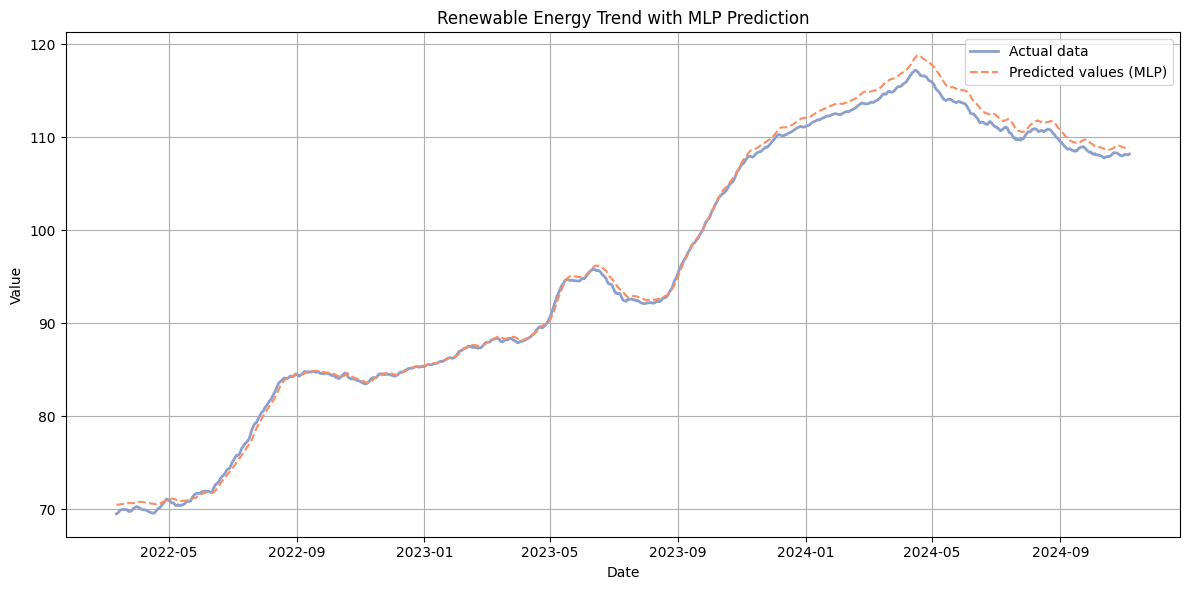

In [12]:
df_lagged = create_lagged_features(renewables_trend_component, n_lags=best_params_renewable['n_lags'])

# Train-test split (time-aware)
train_df = df_lagged.iloc[:split_index]
test_df = df_lagged.iloc[split_index:]

X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Regressor
mlp_model = build_mlp_regressor(hidden_layers_sizes=tuple([best_params_renewable['n_units_layer_0'], best_params_renewable['n_units_layer_1']]), seed=SEED)
mlp_model.fit(X_train_scaled, y_train)

# Predict
trend_forecast = mlp_model.predict(X_test_scaled)

# Evaluate
mape = mean_absolute_percentage_error(y_test, trend_forecast)
r2 = r2_score(y_test, trend_forecast)
print(f"MLP Mean Absolute Percentage Error: {mape:.4f}")
print(f"MLP R-squared: {r2:.4f}")

# Plot
dates = test_df.index
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual data', linewidth=2)
plt.plot(dates, trend_forecast, label='Predicted values (MLP)', linestyle='--')
plt.title('Renewable Energy Trend with MLP Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

MLP Mean Absolute Percentage Error: 0.5623
MLP R-squared: -0.0300


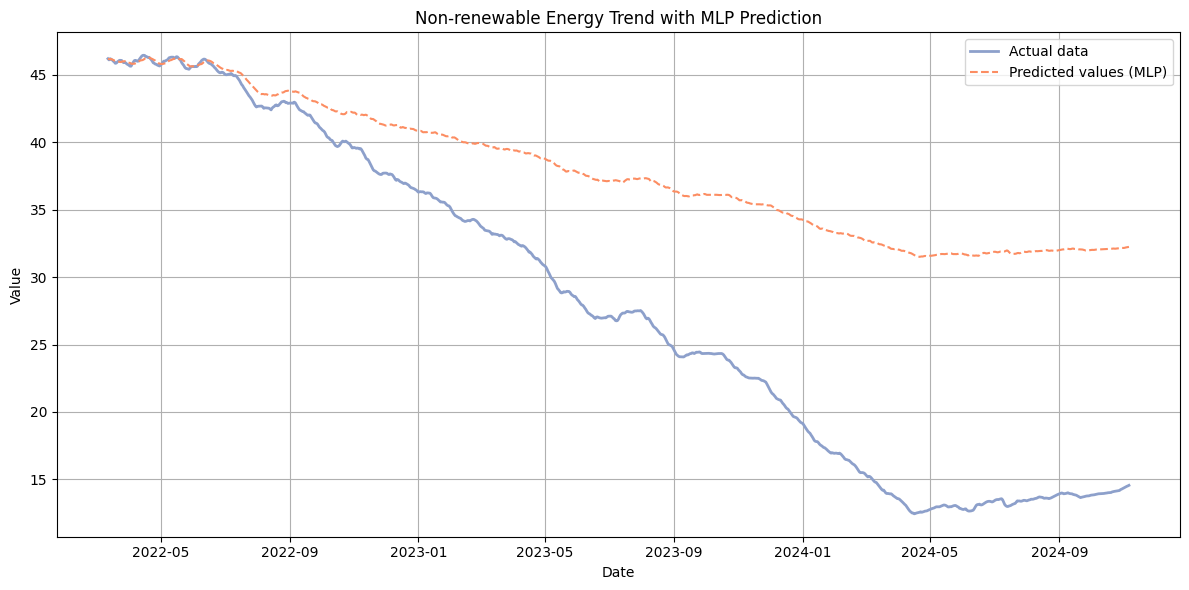

In [13]:
df_lagged = create_lagged_features(non_renewables_trend_component, n_lags=best_params_nonrenewable['n_lags'])

# Train-test split (time-aware)
train_df = df_lagged.iloc[:split_index]
test_df = df_lagged.iloc[split_index:]

X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Regressor
mlp_model = build_mlp_regressor(hidden_layers_sizes=tuple([best_params_nonrenewable['n_units_layer_0'], best_params_nonrenewable['n_units_layer_1']]), seed=SEED)
mlp_model.fit(X_train_scaled, y_train)

# Predict
y_pred = mlp_model.predict(X_test_scaled)

# Evaluate
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MLP Mean Absolute Percentage Error: {mape:.4f}")
print(f"MLP R-squared: {r2:.4f}")

# Plot
dates = test_df.index
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual data', linewidth=2)
plt.plot(dates, y_pred, label='Predicted values (MLP)', linestyle='--')
plt.title('Non-renewable Energy Trend with MLP Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Exponential Smoothing

In [14]:
def trend_exponential_smoothing_regressor(train_dataset: pd.DataFrame, trend_type: str, is_damped: bool):

    model = ExponentialSmoothing(
        train_dataset.values,
        trend=trend_type,
        damped=is_damped,
        seasonal=None
    )

    # Fit the model
    return model.fit(
        smoothing_level=None, 
        smoothing_slope=None, 
        damping_slope=None
    )

def optimize_exponential_smoothing_trend(trend_component, trend_types=['add', 'mul'], is_damped_options=[True, False], steps_ahead=900):
    """
    Optimize hyperparameters for exponential smoothing trend forecasting.
    
    Args:
        trend_component: Time series data of the trend component
        trend_types: List of trend types to try ('add', 'mul')
        is_damped_options: List of damping options to try (True, False)
        steps_ahead: Number of steps ahead to forecast for evaluation
        
    Returns:
        dict: Best hyperparameters (trend_type, is_damped)
        float: Best MAPE score
        float: Best R-squared score
    """
    best_mape = float('inf')
    best_r_squared = 0.
    best_params = {}
    
    # Split the data for validation
    split_idx = int(len(trend_component) * 0.8)
    train_data = trend_component[:split_idx]
    test_data = trend_component[split_idx:]
    
    # Try all combinations of trend_type and damping
    for trend_type in trend_types:
        for is_damped in is_damped_options:
            try:
                # Create and fit the model
                fitted_model = trend_exponential_smoothing_regressor(
                    train_data,
                    trend_type=trend_type,
                    is_damped=is_damped
                )
                
                # Generate forecast
                forecast = fitted_model.forecast(steps=steps_ahead)
                test_data = test_data.iloc[:len(forecast)]
                
                # Calculate MAPE on the test data
                mape = mean_absolute_percentage_error(test_data.values, forecast)
                r_squared = r2_score(test_data.values, forecast)
                
                # Update best parameters if this combination is better
                if mape < best_mape:
                    best_mape = mape
                    best_r_squared = r_squared
                    best_params = {
                        'trend_type': trend_type,
                        'is_damped': is_damped
                    }
            except Exception as e:
                print(f"Error with trend_type={trend_type}, is_damped={is_damped}: {e}")

    return best_params, best_mape, best_r_squared

#### Fine-tuning

In [15]:
# Optimize exponential smoothing for renewable energy trend
print("Optimizing exponential smoothing for renewable energy trend forecasting...")
best_trend_es_params_renewable, best_trend_es_mape_renewable, best_trend_es_r_squared_renewable = optimize_exponential_smoothing_trend(
    renewables_trend_component
)

# Optimize exponential smoothing for non-renewable energy trend
print("\nOptimizing exponential smoothing for non-renewable energy trend forecasting...")
best_trend_es_params_nonrenewable, best_trend_es_mape_nonrenewable, best_trend_es_r_squared_nonrenewable = optimize_exponential_smoothing_trend(
    non_renewables_trend_component
)

# Display the best parameters for both models
print("\nBest parameters for renewable energy trend:")
for param, value in best_trend_es_params_renewable.items():
    print(f"{param}: {value}")
print(f"\nBest results:\nMAPE:\t{best_trend_es_mape_renewable}\nR-squared:\t{best_trend_es_r_squared_renewable}\n")

print("\nBest parameters for non-renewable energy trend:")
for param, value in best_trend_es_params_nonrenewable.items():
    print(f"{param}: {value}")
print(f"\nBest results:\nMAPE:\t{best_trend_es_mape_nonrenewable}\nR-squared:\t{best_trend_es_r_squared_nonrenewable}\n")

# Save to separate JSON files with indentation
with open('best_es_params_renewable.json', 'w') as f:
    json.dump(best_trend_es_params_renewable, f, indent=4)

with open('best_es_params_nonrenewable.json', 'w') as f:
    json.dump(best_trend_es_params_nonrenewable, f, indent=4)

print("\nBest parameters saved to 'best_es_params_renewable.json' and 'best_es_params_nonrenewable.json'")

Optimizing exponential smoothing for renewable energy trend forecasting...

Optimizing exponential smoothing for non-renewable energy trend forecasting...

Best parameters for renewable energy trend:
trend_type: mul
is_damped: False

Best results:
MAPE:	0.042419756249601606
R-squared:	0.8798134906053615


Best parameters for non-renewable energy trend:
trend_type: add
is_damped: False

Best results:
MAPE:	0.19425986514874252
R-squared:	0.8510227478617227


Best parameters saved to 'best_es_params_renewable.json' and 'best_es_params_nonrenewable.json'


#### Best Parameters Forecasting

Exponential Smoothing Mean Absolute Percentage Error: 0.0468
Exponential Smoothing R-squared: 0.8443


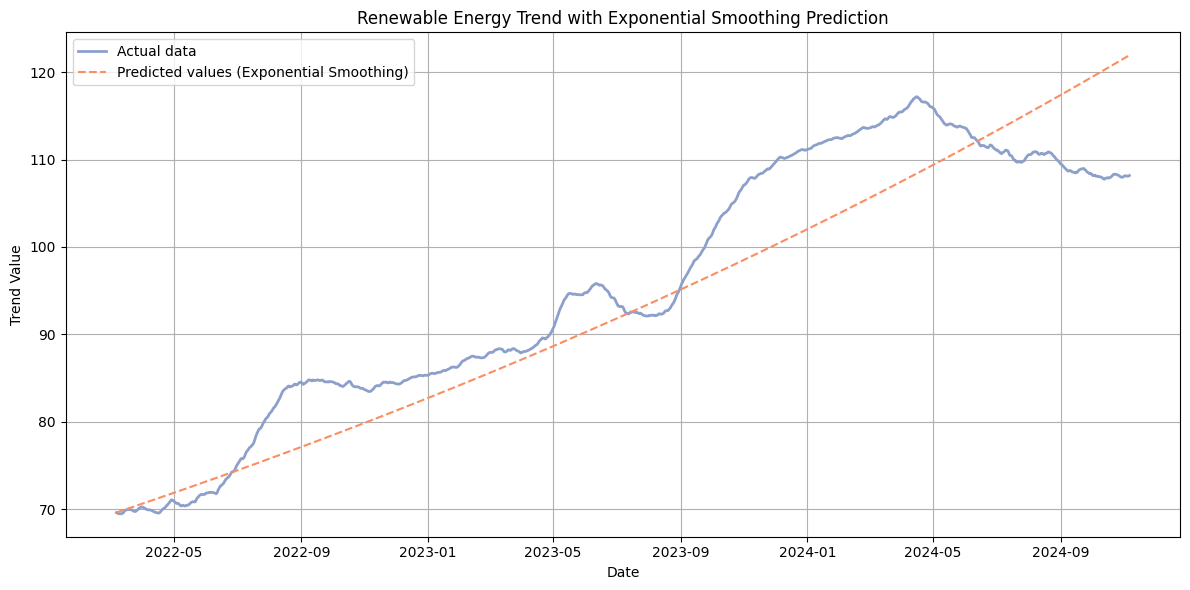

In [16]:
trend_train = renewables_trend_component[:split_index]
trend_test = renewables_trend_component[split_index:]

# Initialize and fit the exponential smoothing model for trend
fitted_model = trend_exponential_smoothing_regressor(
    trend_train,
    trend_type=best_trend_es_params_renewable['trend_type'],
    is_damped=best_trend_es_params_renewable['is_damped']
)

# Generate forecast for the test period
forecast_steps = len(trend_test)
trend_forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the forecast
mape = mean_absolute_percentage_error(trend_test.values[:len(trend_forecast)], trend_forecast)
r2 = r2_score(trend_test.values[:len(trend_forecast)], trend_forecast)
print(f"Exponential Smoothing Mean Absolute Percentage Error: {mape:.4f}")
print(f"Exponential Smoothing R-squared: {r2:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(trend_test.index[:len(trend_forecast)], trend_test.values[:len(trend_forecast)], 
         label='Actual data', linewidth=2)
plt.plot(trend_test.index[:len(trend_forecast)], trend_forecast, 
         label='Predicted values (Exponential Smoothing)', linestyle='--')
plt.title('Renewable Energy Trend with Exponential Smoothing Prediction')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Exponential Smoothing Mean Absolute Percentage Error: 0.1945
Exponential Smoothing R-squared: 0.8645


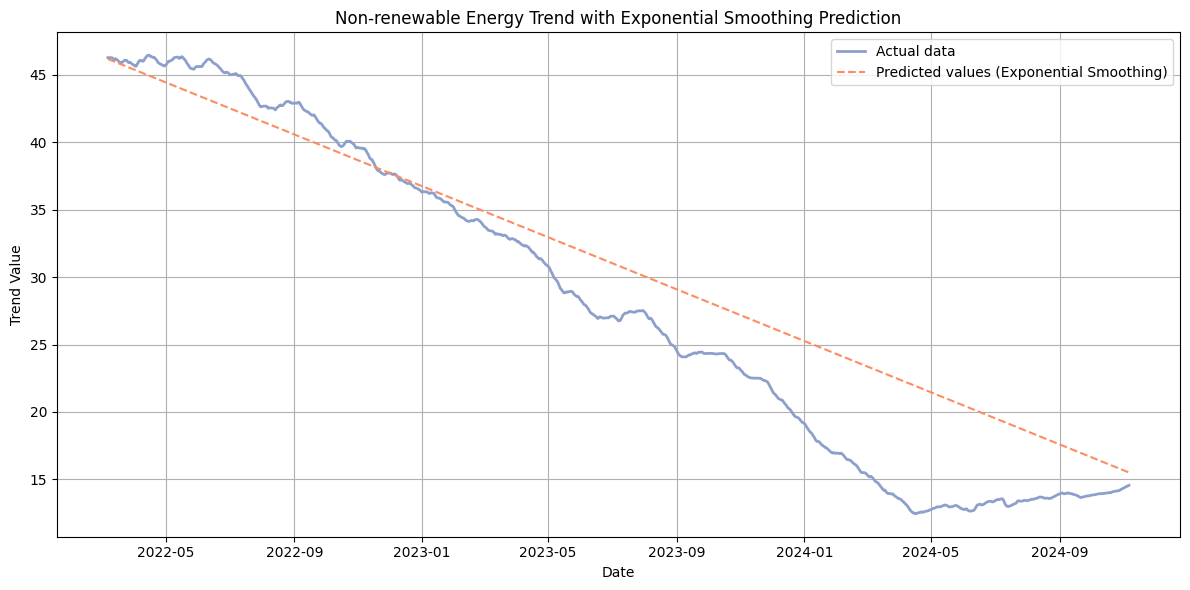

In [17]:
trend_train = non_renewables_trend_component[:split_index]
trend_test = non_renewables_trend_component[split_index:]

# Initialize and fit the exponential smoothing model for trend
fitted_model = trend_exponential_smoothing_regressor(
    trend_train,
    trend_type=best_trend_es_params_nonrenewable['trend_type'],
    is_damped=best_trend_es_params_nonrenewable['is_damped']
)

# Generate forecast for the test period
forecast_steps = len(trend_test)
trend_forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the forecast
mape = mean_absolute_percentage_error(trend_test.values[:len(trend_forecast)], trend_forecast)
r2 = r2_score(trend_test.values[:len(trend_forecast)], trend_forecast)
print(f"Exponential Smoothing Mean Absolute Percentage Error: {mape:.4f}")
print(f"Exponential Smoothing R-squared: {r2:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(trend_test.index[:len(trend_forecast)], trend_test.values[:len(trend_forecast)], 
         label='Actual data', linewidth=2)
plt.plot(trend_test.index[:len(trend_forecast)], trend_forecast, 
         label='Predicted values (Exponential Smoothing)', linestyle='--')
plt.title('Non-renewable Energy Trend with Exponential Smoothing Prediction')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Results

For renewable energy, MLP could generalize better the time series trend (99%) than the exponential smoothing (84%), in opposite to the non-renewables where the exponential smoothing (86%) generalized better its trend compared to the MLP (47%).

## Seasonality Analysis

In [18]:
def seasonality_exponential_smoothing_regressor(train_dataset: pd.DataFrame, seasonal_type: str):

    model = ExponentialSmoothing(
        train_dataset.values,
        trend=None,
        damped=False,
        seasonal=seasonal_type,
        seasonal_periods=SEASONAL_PERIODS
    )

    # Fit the model
    return model.fit(
        smoothing_level=None,
        smoothing_slope=None,
        damping_slope=None
    )

def optimize_exponential_smoothing_seasonality(seasonal_component, seasonal_types=['add', 'mul'], steps_ahead=900):
    """
    Optimize hyperparameters for exponential smoothing trend forecasting.

    Args:
        seasonal_component: Time series data of the trend component
        seasonal_types: List of trend types to try ('add', 'mul')
        is_damped_options: List of damping options to try (True, False)
        steps_ahead: Number of steps ahead to forecast for evaluation

    Returns:
        dict: Best hyperparameters (seasonality_type)
        float: Best MAPE score
        float: Best R-squared score
    """
    best_mape = float('inf')
    best_r_squared = 0.
    best_params = {}

    # Split the data for validation
    split_idx = int(len(seasonal_component) * 0.8)
    train_data = seasonal_component[:split_idx]
    test_data = seasonal_component[split_idx:]

    # Try all combinations of seasonality_type and damping
    for seasonal_type in seasonal_types:
        try:
            # Create and fit the model
            fitted_model = seasonality_exponential_smoothing_regressor(
                train_data,
                seasonal_type=seasonal_type
            )

            # Generate forecast
            forecast = fitted_model.forecast(steps=steps_ahead)
            test_data = test_data.iloc[:len(forecast)]

            # Calculate MAPE on the test data
            mape = mean_absolute_percentage_error(test_data.values, forecast)
            r_squared = r2_score(test_data.values, forecast)

            # Update best parameters if this combination is better
            if mape < best_mape:
                best_mape = mape
                best_r_squared = r_squared
                best_params = {
                    'seasonal_type': seasonal_type
                }
        except Exception as e:
            print(f"Error with seasonal_type={seasonal_type}: {e}")

    return best_params, best_mape, best_r_squared

### Fine-tuning

In [19]:
# Optimize exponential smoothing for renewable energy seasonality
print("Optimizing exponential smoothing for renewable energy seasonality forecasting...")
best_seasonality_es_params_renewable, best_seasonality_es_mape_renewable, best_seasonality_es_r_squared_renewable = optimize_exponential_smoothing_seasonality(
    renewables_seasonal_component
)

# Optimize exponential smoothing for non-renewable energy seasonality
print("\nOptimizing exponential smoothing for non-renewable energy seasonality forecasting...")
best_seasonality_es_params_nonrenewable, best_seasonality_es_mape_nonrenewable, best_seasonality_es_r_squared_nonrenewable = optimize_exponential_smoothing_seasonality(
    non_renewables_seasonal_component
)

# Display the best parameters for both models
print("\nBest parameters for renewable energy seasonality:")
for param, value in best_seasonality_es_params_renewable.items():
    print(f"{param}: {value}")
print(f"\nBest results:\nMAPE:\t{best_seasonality_es_mape_renewable}\nR-squared:\t{best_seasonality_es_r_squared_renewable}\n")

print("\nBest parameters for non-renewable energy seasonality:")
for param, value in best_seasonality_es_params_nonrenewable.items():
    print(f"{param}: {value}")
print(f"\nBest results:\nMAPE:\t{best_seasonality_es_mape_nonrenewable}\nR-squared:\t{best_seasonality_es_r_squared_nonrenewable}\n")

# Save to separate JSON files with indentation
with open('best_es_seasonal_params_renewable.json', 'w') as f:
    json.dump(best_seasonality_es_params_renewable, f, indent=4)

with open('best_es_seasonal_params_nonrenewable.json', 'w') as f:
    json.dump(best_seasonality_es_params_nonrenewable, f, indent=4)

print("\nBest parameters saved to 'best_es_seasonal_params_renewable.json' and 'best_es_seasonal_params_nonrenewable.json'")

Optimizing exponential smoothing for renewable energy seasonality forecasting...

Optimizing exponential smoothing for non-renewable energy seasonality forecasting...

Best parameters for renewable energy seasonality:
seasonal_type: mul

Best results:
MAPE:	1.2685887838720478e-17
R-squared:	1.0


Best parameters for non-renewable energy seasonality:
seasonal_type: mul

Best results:
MAPE:	6.572699278927894e-18
R-squared:	1.0


Best parameters saved to 'best_es_seasonal_params_renewable.json' and 'best_es_seasonal_params_nonrenewable.json'


### Best Parameters Forecasting

Exponential Smoothing Mean Absolute Percentage Error: 0.0000
Exponential Smoothing R-squared: 1.0000


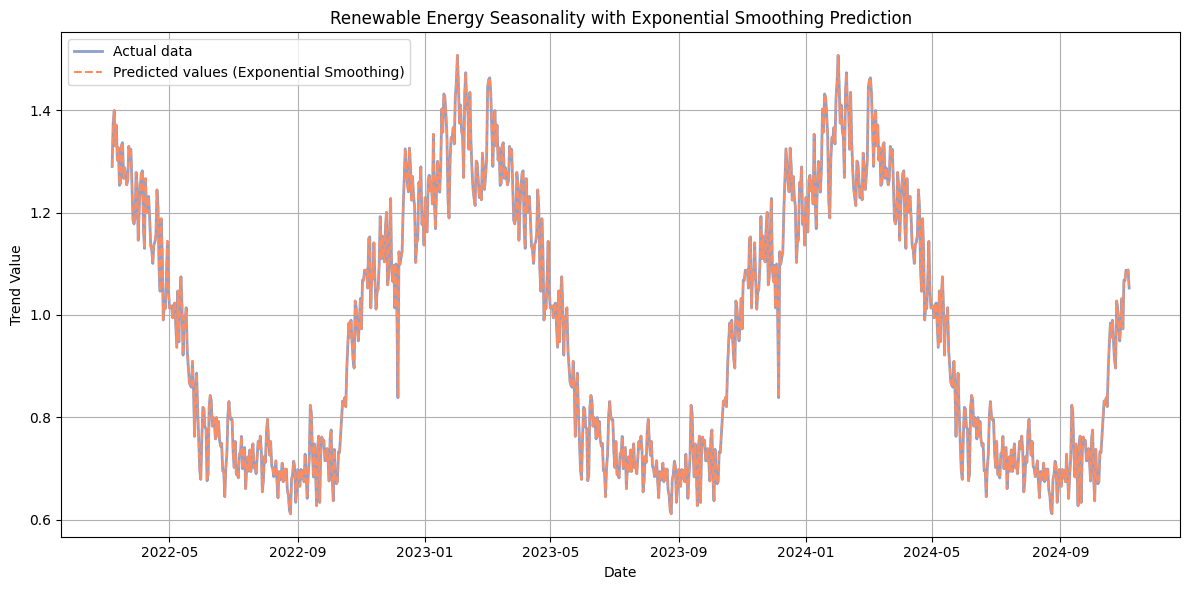

In [20]:
seasonal_train = renewables_seasonal_component[:split_index]
seasonal_test = renewables_seasonal_component[split_index:]

# Initialize and fit the exponential smoothing model for trend
fitted_model = seasonality_exponential_smoothing_regressor(
    seasonal_train,
    seasonal_type=best_seasonality_es_params_renewable['seasonal_type']
)

# Generate forecast for the test period
forecast_steps = len(seasonal_test)
trend_forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the forecast
mape = mean_absolute_percentage_error(seasonal_test.values[:len(trend_forecast)], trend_forecast)
r2 = r2_score(seasonal_test.values[:len(trend_forecast)], trend_forecast)
print(f"Exponential Smoothing Mean Absolute Percentage Error: {mape:.4f}")
print(f"Exponential Smoothing R-squared: {r2:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(seasonal_test.index[:len(trend_forecast)], seasonal_test.values[:len(trend_forecast)], 
         label='Actual data', linewidth=2)
plt.plot(seasonal_test.index[:len(trend_forecast)], trend_forecast, 
         label='Predicted values (Exponential Smoothing)', linestyle='--')
plt.title('Renewable Energy Seasonality with Exponential Smoothing Prediction')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Exponential Smoothing Mean Absolute Percentage Error: 0.0000
Exponential Smoothing R-squared: 1.0000


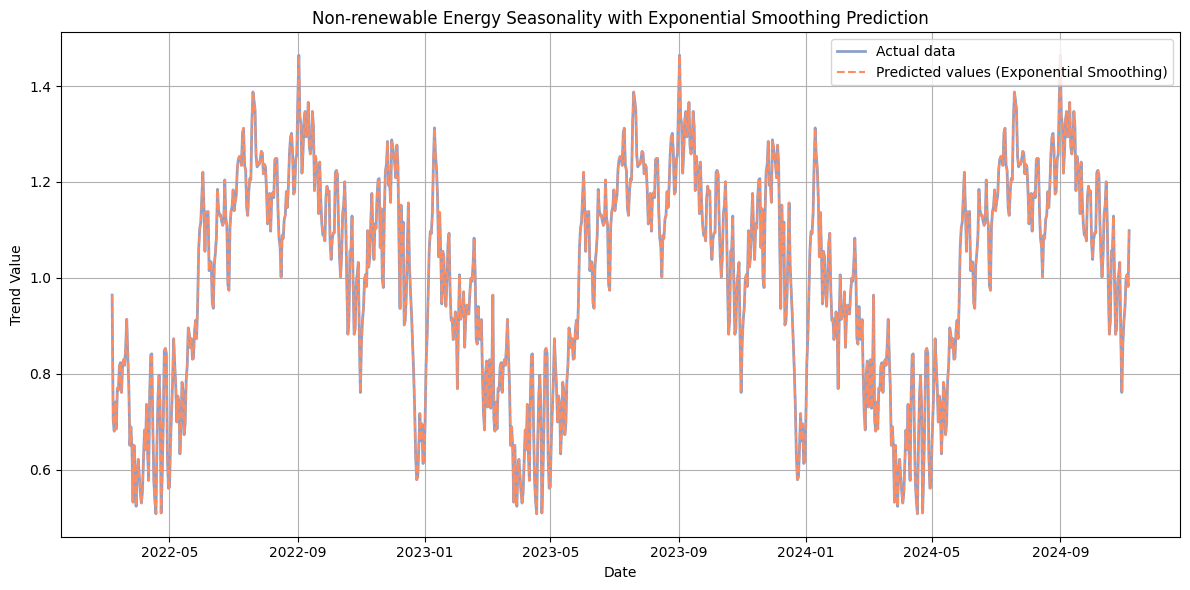

In [21]:
seasonal_train = non_renewables_seasonal_component[:split_index]
seasonal_test = non_renewables_seasonal_component[split_index:]

# Initialize and fit the exponential smoothing model for trend
fitted_model = seasonality_exponential_smoothing_regressor(
    seasonal_train,
    seasonal_type=best_seasonality_es_params_nonrenewable['seasonal_type']
)

# Generate forecast for the test period
forecast_steps = len(seasonal_test)
trend_forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the forecast
mape = mean_absolute_percentage_error(seasonal_test.values[:len(trend_forecast)], trend_forecast)
r2 = r2_score(seasonal_test.values[:len(trend_forecast)], trend_forecast)
print(f"Exponential Smoothing Mean Absolute Percentage Error: {mape:.4f}")
print(f"Exponential Smoothing R-squared: {r2:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(seasonal_test.index[:len(trend_forecast)], seasonal_test.values[:len(trend_forecast)], 
         label='Actual data', linewidth=2)
plt.plot(seasonal_test.index[:len(trend_forecast)], trend_forecast, 
         label='Predicted values (Exponential Smoothing)', linestyle='--')
plt.title('Non-renewable Energy Seasonality with Exponential Smoothing Prediction')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Residuals Analysis

### Multi-Layer Perceptron

In [22]:
def optimize_mlp_for_residuals(residuals_component, n_trials=200):
    """
    Optimize MLP hyperparameters for residuals forecasting using Optuna.

    Args:
        trend_train: Full dataset for residuals component
        n_trials: Number of optimization trials

    Returns:
        dict: Best hyperparameters
    """
    def objective(trial: optuna.trial.Trial):
        # Define hyperparameters to optimize
        hidden_layers = []
        for i in range(2):
            hidden_layers.append(trial.suggest_int(f'n_units_layer_{i}', 15, 200, step=5))

        # Create MLP with the suggested hyperparameters
        mlp = build_mlp_regressor(
            hidden_layers_sizes=tuple(hidden_layers),
            seed=SEED
        )

        # Create lagged features
        n_lags = trial.suggest_int('n_lags', 1, 5)
        df_lagged = create_lagged_features(residuals_component, n_lags=n_lags)

        # Train-test split
        test_split_ratio = 0.8
        split = int(len(df_lagged) * test_split_ratio)
        train_df = df_lagged.iloc[:split]
        test_df = df_lagged.iloc[split:]

        X_train = train_df.drop('y', axis=1).values
        y_train = train_df['y'].values
        X_test = test_df.drop('y', axis=1).values
        y_test = test_df['y'].values

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train and evaluate
        try:
            mlp.fit(X_train_scaled, y_train)
            y_pred = mlp.predict(X_test_scaled)
            mae = mean_absolute_error(y_test, y_pred)
            return mae
        except Exception as e:
            print(f"Error during training: {e}")
            return float('inf')

    # Create study and optimize
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get best hyperparameters
    best_params = study.best_params
    print(f"Best hyperparameters: {best_params}")

    return best_params

#### Fine-tuning

In [23]:
# Optimize MLP for renewable energy residuals
print("Optimizing MLP for renewable energy residuals forecasting...")
best_params_residuals_renewable = optimize_mlp_for_residuals(
    renewables_residual_component
)

# Optimize MLP for non-renewable energy residuals
print("\nOptimizing MLP for non-renewable energy residuals forecasting...")
best_params_residuals_nonrenewable = optimize_mlp_for_residuals(
    renewables_residual_component
)

# Display the best parameters for both models
print("\nBest parameters for renewable energy residuals:")
for param, value in best_params_residuals_renewable.items():
    print(f"{param}: {value}")

print("\nBest parameters for non-renewable energy residuals:")
for param, value in best_params_residuals_nonrenewable.items():
    print(f"{param}: {value}")

# Create dictionaries to store the best parameters
best_params_residuals_renewable_dict = {
    'n_lags': best_params_residuals_renewable['n_lags'],
    'hidden_layers': [
        best_params_residuals_renewable['n_units_layer_0'],
        best_params_residuals_renewable['n_units_layer_1']
    ]
}

best_params_residuals_nonrenewable_dict = {
    'n_lags': best_params_residuals_nonrenewable['n_lags'],
    'hidden_layers': [
        best_params_residuals_nonrenewable['n_units_layer_0'],
        best_params_residuals_nonrenewable['n_units_layer_1']
    ]
}

# Save to separate JSON files with indentation
with open('best_mlp_params_residuals_renewable.json', 'w') as f:
    json.dump(best_params_residuals_renewable_dict, f, indent=4)

with open('best_mlp_params_residuals_nonrenewable.json', 'w') as f:
    json.dump(best_params_residuals_nonrenewable_dict, f, indent=4)

print("\nBest parameters saved to 'best_mlp_params_residuals_renewable.json' and 'best_mlp_params_residuals_nonrenewable.json'")

[I 2025-05-16 11:37:18,907] A new study created in memory with name: no-name-1e958867-1e1c-41a0-ae07-e336a96905e1


Optimizing MLP for renewable energy residuals forecasting...


[I 2025-05-16 11:37:19,228] Trial 0 finished with value: 0.13427454233143218 and parameters: {'n_units_layer_0': 185, 'n_units_layer_1': 80, 'n_lags': 3}. Best is trial 0 with value: 0.13427454233143218.
[I 2025-05-16 11:37:19,345] Trial 1 finished with value: 0.13526256445199486 and parameters: {'n_units_layer_0': 70, 'n_units_layer_1': 25, 'n_lags': 3}. Best is trial 0 with value: 0.13427454233143218.
[I 2025-05-16 11:37:19,456] Trial 2 finished with value: 0.1367928357951479 and parameters: {'n_units_layer_0': 175, 'n_units_layer_1': 40, 'n_lags': 3}. Best is trial 0 with value: 0.13427454233143218.
[I 2025-05-16 11:37:19,707] Trial 3 finished with value: 0.1354950369736906 and parameters: {'n_units_layer_0': 145, 'n_units_layer_1': 150, 'n_lags': 2}. Best is trial 0 with value: 0.13427454233143218.
[I 2025-05-16 11:37:19,875] Trial 4 finished with value: 0.13599022083577872 and parameters: {'n_units_layer_0': 35, 'n_units_layer_1': 165, 'n_lags': 3}. Best is trial 0 with value: 0.1

Best hyperparameters: {'n_units_layer_0': 65, 'n_units_layer_1': 85, 'n_lags': 4}

Optimizing MLP for non-renewable energy residuals forecasting...


[I 2025-05-16 11:37:57,362] Trial 1 finished with value: 0.13625784885701386 and parameters: {'n_units_layer_0': 145, 'n_units_layer_1': 155, 'n_lags': 1}. Best is trial 1 with value: 0.13625784885701386.
[I 2025-05-16 11:37:57,612] Trial 2 finished with value: 0.136118212789397 and parameters: {'n_units_layer_0': 50, 'n_units_layer_1': 165, 'n_lags': 5}. Best is trial 2 with value: 0.136118212789397.
[I 2025-05-16 11:37:58,013] Trial 3 finished with value: 0.1351316922895016 and parameters: {'n_units_layer_0': 150, 'n_units_layer_1': 90, 'n_lags': 2}. Best is trial 3 with value: 0.1351316922895016.
[I 2025-05-16 11:37:58,165] Trial 4 finished with value: 0.13791896463869438 and parameters: {'n_units_layer_0': 15, 'n_units_layer_1': 105, 'n_lags': 5}. Best is trial 3 with value: 0.1351316922895016.
[I 2025-05-16 11:37:58,351] Trial 5 finished with value: 0.13668220967274816 and parameters: {'n_units_layer_0': 15, 'n_units_layer_1': 180, 'n_lags': 5}. Best is trial 3 with value: 0.13513

Best hyperparameters: {'n_units_layer_0': 200, 'n_units_layer_1': 35, 'n_lags': 4}

Best parameters for renewable energy residuals:
n_units_layer_0: 65
n_units_layer_1: 85
n_lags: 4

Best parameters for non-renewable energy residuals:
n_units_layer_0: 200
n_units_layer_1: 35
n_lags: 4

Best parameters saved to 'best_mlp_params_residuals_renewable.json' and 'best_mlp_params_residuals_nonrenewable.json'


#### Best Parameters Forecasting

MLP Mean Absolute Percentage Error: 0.1382
MLP R-squared: 0.5389


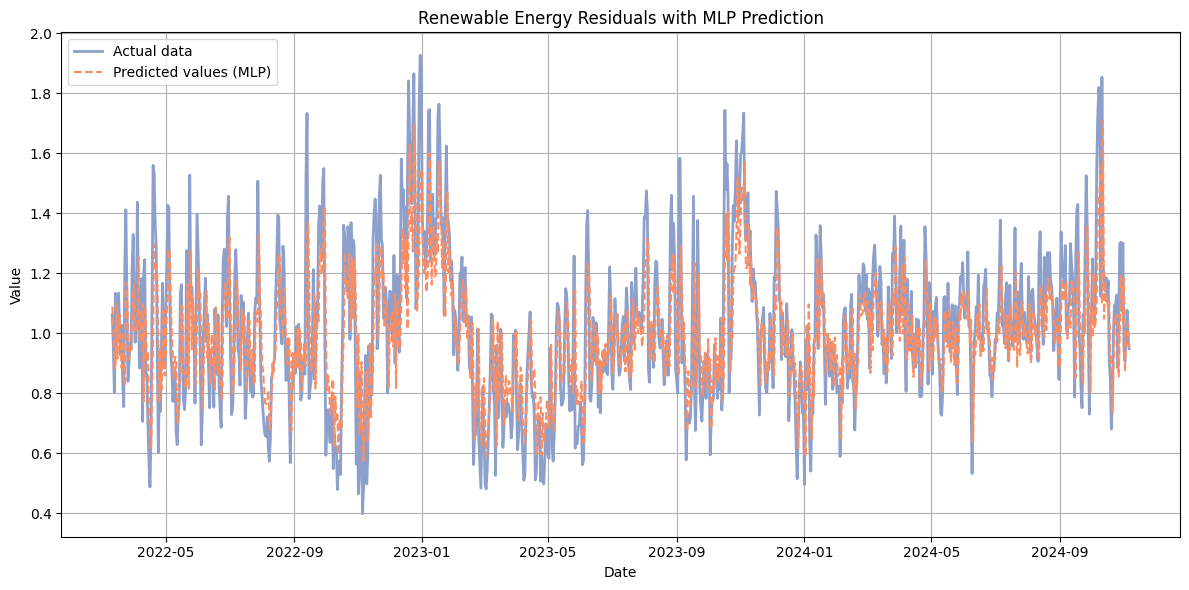

In [24]:
df_lagged = create_lagged_features(renewables_residual_component, n_lags=best_params_residuals_renewable['n_lags'])

# Train-test split (time-aware)
train_df = df_lagged.iloc[:split_index]
test_df = df_lagged.iloc[split_index:]

X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Regressor
mlp_model = build_mlp_regressor(hidden_layers_sizes=tuple([best_params_residuals_renewable['n_units_layer_0'], best_params_residuals_renewable['n_units_layer_1']]), seed=SEED)
mlp_model.fit(X_train_scaled, y_train)

# Predict
trend_forecast = mlp_model.predict(X_test_scaled)

# Evaluate
mape = mean_absolute_percentage_error(y_test, trend_forecast)
r2 = r2_score(y_test, trend_forecast)
print(f"MLP Mean Absolute Percentage Error: {mape:.4f}")
print(f"MLP R-squared: {r2:.4f}")

# Plot
dates = test_df.index
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual data', linewidth=2)
plt.plot(dates, trend_forecast, label='Predicted values (MLP)', linestyle='--')
plt.title('Renewable Energy Residuals with MLP Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

MLP Mean Absolute Percentage Error: 0.5282
MLP R-squared: 0.5311


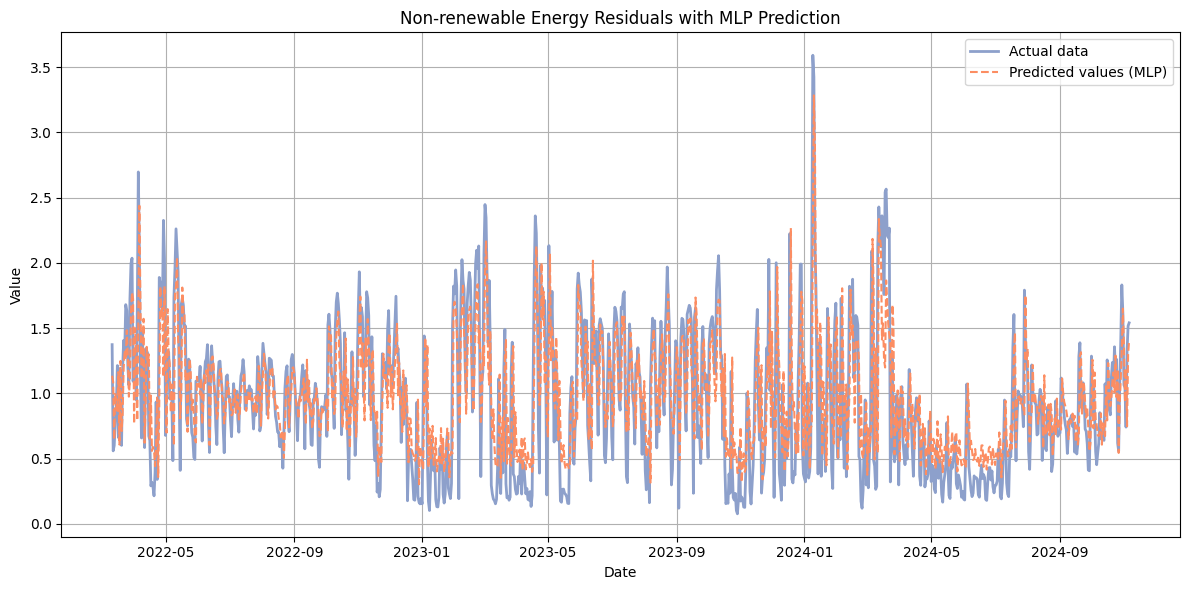

In [25]:
df_lagged = create_lagged_features(non_renewables_residual_component, n_lags=best_params_residuals_nonrenewable['n_lags'])

# Train-test split (time-aware)
train_df = df_lagged.iloc[:split_index]
test_df = df_lagged.iloc[split_index:]

X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Regressor
mlp_model = build_mlp_regressor(hidden_layers_sizes=tuple([best_params_residuals_nonrenewable['n_units_layer_0'], best_params_residuals_nonrenewable['n_units_layer_1']]), seed=SEED)
mlp_model.fit(X_train_scaled, y_train)

# Predict
trend_forecast = mlp_model.predict(X_test_scaled)

# Evaluate
mape = mean_absolute_percentage_error(y_test, trend_forecast)
r2 = r2_score(y_test, trend_forecast)
print(f"MLP Mean Absolute Percentage Error: {mape:.4f}")
print(f"MLP R-squared: {r2:.4f}")

# Plot
dates = test_df.index
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual data', linewidth=2)
plt.plot(dates, trend_forecast, label='Predicted values (MLP)', linestyle='--')
plt.title('Non-renewable Energy Residuals with MLP Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### SVR

In [26]:
def optimize_svr_for_residuals(residuals_dataset, n_lags=5, n_trials=200):
    """
    Train and tune an SVR model using Optuna for hyperparameter optimization.

    Parameters:
        df_train (pd.Series): Training series.
        df_test (pd.Series): Testing series.
        n_lags (int): Number of lagged features to create.
        n_trials (int): Number of Optuna trials.

    Returns:
        tuple: (best_model, best_params)
    """

    def objective(trial):
        # Create lagged features
        n_lags = trial.suggest_int('n_lags', 1, 5)
        df_lagged = create_lagged_features(residuals_dataset, n_lags=n_lags)

        # Train-test split (time-aware)
        split = int(len(df_lagged) * 0.8)
        train_df = df_lagged.iloc[:split]
        test_df = df_lagged.iloc[split:]

        X_train = train_df.drop(columns='y').values
        y_train = train_df['y'].values
        X_test = test_df.drop(columns='y').values
        y_test = test_df['y'].values

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)


        # Define hyperparameters to optimize
        C = trial.suggest_float('C', 0.1, 100.0, log=True)
        epsilon = trial.suggest_float('epsilon', 0.01, 1.0, log=True)
        
        # Handle gamma parameter (can be 'auto', 'scale', or a specific value)
        gamma_type = trial.suggest_categorical('gamma_type', ['value', 'auto'])
        if gamma_type == 'value':
            gamma = trial.suggest_float('gamma', 0.001, 1.0, log=True)
        else:
            gamma = 'auto'
        
        # Create SVR model with the suggested hyperparameters
        svr_model = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
        
        # Train the model
        try:
            svr_model.fit(X_train_scaled, y_train)
            
            # Predict on test data
            y_pred = svr_model.predict(X_test_scaled)
            
            # Calculate MAE as the objective to minimize
            mae = mean_absolute_error(y_test, y_pred)
            return mae
        except Exception as e:
            print(f"Error in SVR training: {e}")
            return float('inf')
    
    # Create and run the Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    # Get best parameters and train final model
    best_params = study.best_params
    print("Best Parameters:", best_params)

    return best_params

#### Fine-tuning

In [27]:
# Optimize SVR for renewable energy residuals
print("Optimizing SVR for renewable energy residuals forecasting...")
best_params_svr_renewable = optimize_svr_for_residuals(
    renewables_residual_component
)

# Optimize SVR for non-renewable energy residuals
print("\nOptimizing SVR for non-renewable energy residuals forecasting...")
best_params_svr_nonrenewable = optimize_svr_for_residuals(
    non_renewables_residual_component
)

# Display the best parameters for both models
print("\nBest SVR parameters for renewable energy residuals:")
for param, value in best_params_svr_renewable.items():
    print(f"{param}: {value}")

print("\nBest SVR parameters for non-renewable energy residuals:")
for param, value in best_params_svr_nonrenewable.items():
    print(f"{param}: {value}")

# Save to separate JSON files with indentation
with open('best_svr_params_residuals_renewable.json', 'w') as f:
    json.dump(best_params_svr_renewable, f, indent=4)

with open('best_svr_params_residuals_nonrenewable.json', 'w') as f:
    json.dump(best_params_svr_nonrenewable, f, indent=4)

print("\nBest parameters saved to 'best_svr_params_residuals_renewable.json' and 'best_svr_params_residuals_nonrenewable.json'")


[I 2025-05-16 11:38:34,637] A new study created in memory with name: no-name-1b355c33-7736-4f93-a538-b1a0277f283a
[I 2025-05-16 11:38:34,669] Trial 0 finished with value: 0.17145231642525297 and parameters: {'n_lags': 3, 'C': 0.9617461047122754, 'epsilon': 0.5685919683695885, 'gamma_type': 'value', 'gamma': 0.5849380953453288}. Best is trial 0 with value: 0.17145231642525297.


Optimizing SVR for renewable energy residuals forecasting...


[I 2025-05-16 11:38:34,745] Trial 1 finished with value: 0.14216951736911557 and parameters: {'n_lags': 2, 'C': 46.60350546986356, 'epsilon': 0.3857899108950823, 'gamma_type': 'auto'}. Best is trial 1 with value: 0.14216951736911557.
[I 2025-05-16 11:38:34,999] Trial 2 finished with value: 0.13479064169758237 and parameters: {'n_lags': 4, 'C': 9.731746482421588, 'epsilon': 0.045832391884263905, 'gamma_type': 'value', 'gamma': 0.006152723311143238}. Best is trial 2 with value: 0.13479064169758237.
[I 2025-05-16 11:38:35,307] Trial 3 finished with value: 0.13461707163354672 and parameters: {'n_lags': 2, 'C': 83.32195600464681, 'epsilon': 0.012039020676597659, 'gamma_type': 'value', 'gamma': 0.00679293215907489}. Best is trial 3 with value: 0.13461707163354672.
[I 2025-05-16 11:38:36,598] Trial 4 finished with value: 0.13747089045754404 and parameters: {'n_lags': 4, 'C': 60.605589749233886, 'epsilon': 0.118860646361175, 'gamma_type': 'auto'}. Best is trial 3 with value: 0.1346170716335467

Best Parameters: {'n_lags': 3, 'C': 0.10378037769432671, 'epsilon': 0.11702983575779023, 'gamma_type': 'auto'}

Optimizing SVR for non-renewable energy residuals forecasting...


[I 2025-05-16 11:39:14,462] Trial 1 finished with value: 0.3335880862287963 and parameters: {'n_lags': 4, 'C': 56.73008349658202, 'epsilon': 0.08787184331794327, 'gamma_type': 'auto'}. Best is trial 1 with value: 0.3335880862287963.
[I 2025-05-16 11:39:14,861] Trial 2 finished with value: 0.27968259840798726 and parameters: {'n_lags': 3, 'C': 55.71761487162182, 'epsilon': 0.025354511104595415, 'gamma_type': 'value', 'gamma': 0.02149506053260869}. Best is trial 2 with value: 0.27968259840798726.
[I 2025-05-16 11:39:15,095] Trial 3 finished with value: 0.29419113854139717 and parameters: {'n_lags': 2, 'C': 2.8323363308209437, 'epsilon': 0.07145997058378425, 'gamma_type': 'value', 'gamma': 0.36140129043767294}. Best is trial 2 with value: 0.27968259840798726.
[I 2025-05-16 11:39:15,384] Trial 4 finished with value: 0.28958386364105254 and parameters: {'n_lags': 5, 'C': 0.32850645175515397, 'epsilon': 0.014442955789849183, 'gamma_type': 'auto'}. Best is trial 2 with value: 0.27968259840798

Best Parameters: {'n_lags': 3, 'C': 18.70698931651695, 'epsilon': 0.010545260662286917, 'gamma_type': 'value', 'gamma': 0.02116829182768353}

Best SVR parameters for renewable energy residuals:
n_lags: 3
C: 0.10378037769432671
epsilon: 0.11702983575779023
gamma_type: auto

Best SVR parameters for non-renewable energy residuals:
n_lags: 3
C: 18.70698931651695
epsilon: 0.010545260662286917
gamma_type: value
gamma: 0.02116829182768353

Best parameters saved to 'best_svr_params_residuals_renewable.json' and 'best_svr_params_residuals_nonrenewable.json'


#### Best Parameters Forecasting

SVR Mean Absolute Percentage Error: 0.1383
SVR R-squared: 0.5465


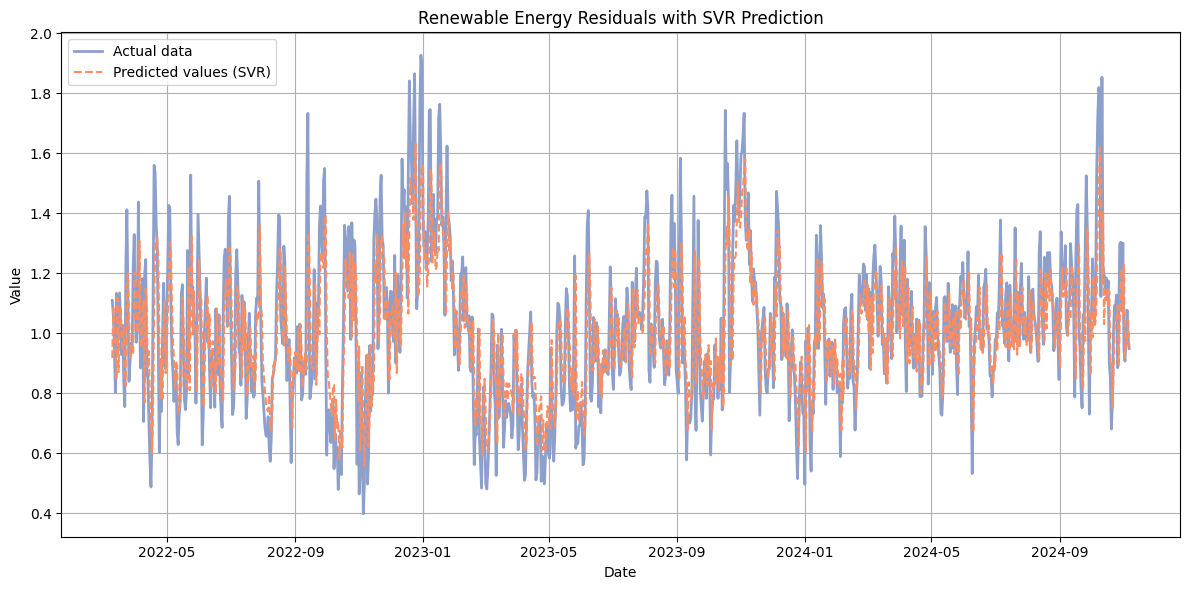

In [28]:
df_lagged = create_lagged_features(renewables_residual_component, n_lags=best_params_svr_renewable['n_lags'])

# Train-test split (time-aware)
train_df = df_lagged.iloc[:split_index]
test_df = df_lagged.iloc[split_index:]

X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle gamma parameter
if best_params_svr_renewable['gamma_type'] == 'value':
    gamma = best_params_svr_renewable['gamma']
else:
    gamma = 'auto'

# Train SVR model
svr_model = SVR(kernel='rbf', 
                C=best_params_svr_renewable['C'], 
                gamma=gamma, 
                epsilon=best_params_svr_renewable['epsilon'])
svr_model.fit(X_train_scaled, y_train)

# Predict
forecast = svr_model.predict(X_test_scaled)

# Evaluate
mape = mean_absolute_percentage_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
print(f"SVR Mean Absolute Percentage Error: {mape:.4f}")
print(f"SVR R-squared: {r2:.4f}")

# Plot
dates = test_df.index
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual data', linewidth=2)
plt.plot(dates, forecast, label='Predicted values (SVR)', linestyle='--')
plt.title('Renewable Energy Residuals with SVR Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

SVR Mean Absolute Percentage Error: 0.4919
SVR R-squared: 0.5244


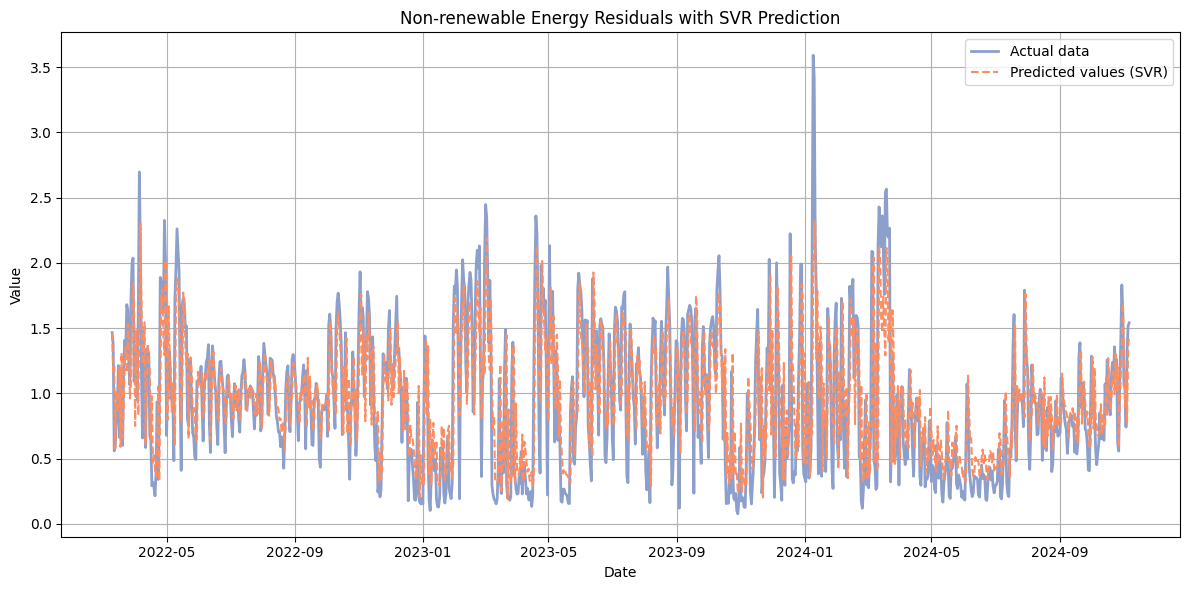

In [29]:
df_lagged = create_lagged_features(non_renewables_residual_component, n_lags=best_params_svr_nonrenewable['n_lags'])

# Train-test split (time-aware)
train_df = df_lagged.iloc[:split_index]
test_df = df_lagged.iloc[split_index:]

X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].values
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle gamma parameter
if best_params_svr_nonrenewable['gamma_type'] == 'value':
    gamma = best_params_svr_nonrenewable['gamma']
else:
    gamma = 'auto'

# Train SVR model
svr_model = SVR(kernel='rbf', 
                C=best_params_svr_nonrenewable['C'], 
                gamma=gamma, 
                epsilon=best_params_svr_nonrenewable['epsilon'])
svr_model.fit(X_train_scaled, y_train)

# Predict
forecast = svr_model.predict(X_test_scaled)

# Evaluate
mape = mean_absolute_percentage_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
print(f"SVR Mean Absolute Percentage Error: {mape:.4f}")
print(f"SVR R-squared: {r2:.4f}")

# Plot
dates = test_df.index
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual data', linewidth=2)
plt.plot(dates, forecast, label='Predicted values (SVR)', linestyle='--')
plt.title('Non-renewable Energy Residuals with SVR Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Hybrid Definition

Even though the MLP for renewables has a good fit (considering that the data are time series residuals), the SVR model has a more stable prediction comparing both renewable energy production and non-renewable energy production.

The best approach is to combine different models for each decomposed component:

1. **Trend Component:**
    - For renewables: MLP Regressor (R-suqared = 0.99)
    - For non-renewables: Exponential Smoothing (R-squared = 0.86)

2. **Seasonal Component:**
    - For both renewables and non-renewables: Multiplicative Exponential Smoothing

3. **Residual Component:**
    - SVR with optimized hyperparameters for both renewable and non-renewable energy

This hybrid approach leverages the strengths of each model type for the specific patterns in each component, resulting in more accurate forecasts compared to using a single model for the entire series.